In [ ]:
import pandas as pd
!pip install yfinance
import csv
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Get the fish data
##### These files are for reference only, the actual files themselves can be found here under "datafiler": https://www.fiskeridir.no/Tall-og-analyse/AApne-data/Fangstdata-seddel-koblet-med-fartoeydata
fields = ['Landingstidspunkt', 'Bruttovekt']
df1 = pd.read_csv('fangstdata_2022.csv', sep=';', error_bad_lines=False, usecols=fields,)
df2 = pd.read_csv('fangstdata_2021.csv', sep=';', error_bad_lines=False, usecols=fields,)
df3 = pd.read_csv('fangstdata_2020.csv', sep=';', error_bad_lines=False, usecols=fields,)
df4 = pd.read_csv('fangstdata_2019.csv', sep=';', error_bad_lines=False, usecols=fields,)
df5 = pd.read_csv('fangstdata_2018.csv', sep=';', error_bad_lines=False, usecols=fields,)
df6 = pd.read_csv('fangstdata_2017.csv', sep=';', error_bad_lines=False, usecols=fields,)
df7 = pd.read_csv('fangstdata_2016.csv', sep=';', error_bad_lines=False, usecols=fields,)
df8 = pd.read_csv('fangstdata_2015.csv', sep=';', error_bad_lines=False, usecols=fields,)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (118) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df = pd.concat([df1, df2, df3, df4, df5, df6])
print("before", df.head())

df['Bruttovekt'] = df['Bruttovekt'].str.replace(',', '.').astype('float64')

n = len(pd.unique(df['Landingstidspunkt']))

df = df.groupby(['Landingstidspunkt']).sum().reset_index()

df['Landingstidspunkt'] = pd.to_datetime(df['Landingstidspunkt'], dayfirst=True)
df = df.sort_values(by=['Landingstidspunkt'], ascending=True)
df.sort_values(by='Landingstidspunkt',ascending=False)
df = df.groupby(['Landingstidspunkt']).sum().reset_index()
df.index = df["Landingstidspunkt"]
#df.to_csv('output.csv', columns = fields)
del df["Landingstidspunkt"]
fishData = df
fishData.index = fishData.index.date
print("after", fishData)

before   Landingstidspunkt Bruttovekt
0        11.01.2022      15960
1        19.01.2022      45846
2        21.02.2022    1174337
3        24.02.2022     498482
4        24.02.2022     445022
after             Bruttovekt
2017-01-01     4711.50
2017-01-02   945065.20
2017-01-03  1033839.50
2017-01-04  3987352.70
2017-01-05  4122843.20
...                ...
2022-09-16  5042996.71
2022-09-17  2922763.68
2022-09-18   592341.29
2022-09-19  2197123.82
2022-09-23       95.00

[2089 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (118) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


     Landingstidspunkt Bruttovekt
0  24.02.2016 15:44:00     351395
1  12.02.2016 10:11:00     195807
2  25.02.2016 09:46:00     154961
3  22.02.2016 20:08:00     486126
4  14.03.2016 12:58:00    2618478
after             Bruttovekt
2017-01-01      4711.5
2017-01-02    945065.2
2017-01-03   1033839.5
2017-01-04   3987352.7
2017-01-05   4122843.2


In [ ]:
# Get stock data (y_train)
ticker, stockName, startDatoPåDataYYYYMMDD = "SALM.OL", "Salmar", "2017-01-01"

stockName = yf.Ticker(ticker)
stockName = stockName.history(start=startDatoPåDataYYYYMMDD, end="2022-09-19")
stockName.index = pd.to_datetime(stockName.index).tz_convert(None).date


del stockName["Dividends"]
del stockName["Stock Splits"]
del stockName["High"]
del stockName["Low"]
del stockName["Volume"]
del stockName["Close"]

print()
print(stockName)



                  Open
2017-01-01  198.490503
2017-01-02  198.876222
2017-01-03  197.179077
2017-01-04  194.479062
2017-01-05  186.301827
...                ...
2022-09-11  630.500000
2022-09-12  638.000000
2022-09-13  631.500000
2022-09-14  632.500000
2022-09-15  618.000000

[1433 rows x 1 columns]


fishdata: (2089, 1)
stockdata: (1433, 1)
(1433, 3)


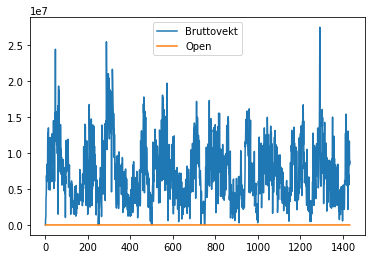

In [ ]:
# merge datasets
print("fishdata:", fishData.shape)
print("stockdata:", stockName.shape)

result = pd.merge(fishData, stockName, left_index=True, right_index=True)
result.reset_index(inplace=True)
print(result.shape)
result.plot()

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))

fish_train = result.iloc[0:1300]
fish_train_dates = fish_train['index']
fish_test = result.iloc[1300:]
fish_test_dates = fish_test['index']

fish_test = result.iloc[1300:, 1:]
fish_train = result.iloc[0:1300, 1:]
print(fish_train.head)
fish_train_scaled = sc.fit_transform(fish_train)
fish_test_scaled = sc.fit_transform(fish_test)


print("fish_train_scaled shape", fish_train_scaled.shape)
print("fish_test_scaled shape", fish_test_scaled.shape)

<bound method NDFrame.head of       Bruttovekt        Open
0        4711.50  198.490503
1      945065.20  198.876222
2     1033839.50  197.179077
3     3987352.70  194.479062
4     4122843.20  186.301827
...          ...         ...
1295  5929325.85  630.063103
1296  5378268.56  639.568461
1297  5599160.86  665.368434
1298  6184994.32  644.806011
1299  8851446.08  617.454122

[1300 rows x 2 columns]>
(133, 2)
fish_train_scaled shape (1300, 2)
fish_test_scaled shape (133, 2)


In [ ]:
sc2 = MinMaxScaler()
fish_train_scaled_y = sc2.fit_transform(fish_train[['Open']])
print("fish_train_scaled_y shape", fish_train_scaled_y.shape)

fish_train_scaled_y shape (1300, 1)


In [ ]:
hops = 5
no_entries = fish_train_scaled.shape[0]
no_variables = 6
X_train = []
Y_train = []
for i in range(hops, no_entries):
    X_train.append(fish_train_scaled[i-hops:i, :1])
    Y_train.append(fish_train_scaled_y[i][0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)

X_train shape (1295, 5, 1)
Y_train shape (1295,)


In [ ]:
# gotta turn into 3D array to fit model
X_train_shape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
print(X_train_shape.shape)

(1295, 5, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(hops, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(hops, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model = Sequential()
model.add(InputLayer((hops,1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train_shape, Y_train, epochs=50, batch_size=10, validation_split=0.1)

In [ ]:
fish_train_last10 = fish_train.iloc[-hops:]
full_df = pd.concat((fish_train_last10, fish_test), axis=0)
print(full_df.shape)

(138, 2)


In [ ]:
full_df = sc.transform(full_df)
print(full_df.shape)

(138, 2)


In [ ]:

no_entries_test = full_df.shape[0]

no_variables_test = 1
X_train_shape_pred = []
for i in range(hops, no_entries_test):
    X_train_shape_pred.append(full_df[i-hops:i, :1])
X_train_shape_pred = np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(133, 5, 1)


In [ ]:
ytest = model.predict(X_train_shape_pred)

5/5 [==============================] - 0s 5ms/step


In [ ]:
y_final_pred = sc2.inverse_transform(ytest)

In [ ]:
final_price_pred = pd.DataFrame(y_final_pred)
final_price_pred.columns = ['final_price_pred']
final_price_pred.index = fish_test.index
print(final_price_pred.shape)
print(fish_test.shape)

(133, 1)
(133, 2)


In [ ]:
final_thing = pd.concat((final_price_pred, fish_test), axis=1)
print(final_thing.head())

      final_price_pred   Bruttovekt        Open
1300        344.956329   9931669.58  595.339838
1301        337.947540   7178720.05  578.851119
1302        331.986694  16046212.23  607.172909
1303        304.489075  13717850.32  608.530825
1304        258.117249  14945620.21  623.661656


In [ ]:
final_thing['tomorrow'] = final_thing['final_price_pred'].shift(-1)
final_thing['prediction'] = (final_thing['final_price_pred'] < final_thing['tomorrow']).astype(int)
print(final_thing.head())

      final_price_pred   Bruttovekt        Open    tomorrow  prediction
1300        344.956329   9931669.58  595.339838  337.947540           0
1301        337.947540   7178720.05  578.851119  331.986694           0
1302        331.986694  16046212.23  607.172909  304.489075           0
1303        304.489075  13717850.32  608.530825  258.117249           0
1304        258.117249  14945620.21  623.661656  199.483582           0


In [ ]:
final_thing['actual_tomorrow'] = final_thing['Open'].shift(-1)
final_thing['actual_change'] = (final_thing['actual_tomorrow'] > final_thing['Open']).astype(int)
print(final_thing.head())

      final_price_pred   Bruttovekt        Open    tomorrow  prediction  \
1300        344.956329   9931669.58  595.339838  337.947540           0   
1301        337.947540   7178720.05  578.851119  331.986694           0   
1302        331.986694  16046212.23  607.172909  304.489075           0   
1303        304.489075  13717850.32  608.530825  258.117249           0   
1304        258.117249  14945620.21  623.661656  199.483582           0   

      actual_change  actual_tomorrow  
1300              0       578.851119  
1301              1       607.172909  
1302              1       608.530825  
1303              1       623.661656  
1304              0       622.303734  


In [ ]:
final_thing['correct_prediction'] = (final_thing['actual_change'] == final_thing['prediction']).astype(int)
print(final_thing.head())
print("\nprediction correctness:", final_thing['correct_prediction'].mean())

      final_price_pred   Bruttovekt        Open    tomorrow  prediction  \
1300        344.956329   9931669.58  595.339838  337.947540           0   
1301        337.947540   7178720.05  578.851119  331.986694           0   
1302        331.986694  16046212.23  607.172909  304.489075           0   
1303        304.489075  13717850.32  608.530825  258.117249           0   
1304        258.117249  14945620.21  623.661656  199.483582           0   

      actual_change  actual_tomorrow  correct_prediction  
1300              0       578.851119                   1  
1301              1       607.172909                   0  
1302              1       608.530825                   0  
1303              1       623.661656                   0  
1304              0       622.303734                   1  

prediction correctness: 0.5263157894736842
